## Image Classification

## 1. Load Packages and Obtain Data

Make sure you have `Keras3` installed.

In [ ]:
!pip install keras --upgrade

In [3]:
import os
os.environ["KERAS_BACKEND"] = "jax" # other choices: tensorflow, torch

# Note that keras should only be imported after the backend
import keras
from keras import utils, layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
keras.__version__

'3.0.5'

Now, let’s access the data. We’ll use a sample data set from Kaggle that contains labeled images of cats and dogs.

In [4]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # 40% for training, 10% for validation, and 10% for test (the rest unused)
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteNSX9LB/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


By running this code, we have created `Dataset`s for training, validation, and testing. You can think of a `Dataset` as a pipeline that feeds data to a machine learning model. We use data sets in cases in which it’s not necessarily practical to load all the data into memory.

The dataset contains images of different sizes, so we resize them to a fixed size of 150x150.

In [5]:
# keras resizing function
resize_fn = keras.layers.Resizing(150, 150)
# map applies a transformation func to each element of the dataset
# x is the features, y is the target --> so we are essentially resizing the features while leaving the target alone
train_ds = train_ds.map(lambda x, y: (resize_fn(x), y)) # so the resizing transformation is applied to everything in train_ds
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

The next block is technical code related to rapidly reading data. The `batch_size` determines how many data points are gathered from the directory at once.

 -  A batch size of 64 means that 64 data points (e.g., images and their labels) will be processed at a time.
 
 - `train_ds.batch(batch_size)` takes the training dataset (`train_ds`) and groups the data into batches of the specified size (64 in this case).
 
 - `.prefetch(tf_data.AUTOTUNE)` is used to prepare or "prefetch" the next batch while the current batch is being processed to improve efficiency. `tf_data.AUTOTUNE` allows TensorFlow to automatically manage the buffer size for prefetching, optimizing this process dynamically.
 
 - `.cache()` caches the elements of the dataset in memory. After the first epoch (a full iteration over the dataset), the data will be loaded from the fast cache rather than from the slower original source.

In [6]:
from tensorflow import data as tf_data
batch_size = 64

# fetch a batch of 64 data points at a time for faster processing time
train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

### Working with Datasets
`two_rows` will take a tensorflow dataset as input and out put 2 rows of images. In the first row, it will show three random pictures of cats. In the second row, it will show three random pictures of dogs.


In [7]:
class_names = ['cat', 'dog']

In [9]:
def two_rows(ds):
  # Create 2 separate datasets for each label respectively
  class_0_ds = ds.filter(lambda image, label: label[0]==0)
  class_1_ds = ds.filter(lambda image, label: label[0]==1)

  # take 3 random images and their labels from each dataset
  class_0_samples = class_0_ds.take(3)
  class_1_samples = class_1_ds.take(3)

  for i, (image_batch, label_batch) in enumerate(class_0_samples):
    # take the first image of the batch
    image = image_batch[0].numpy().astype("uint8")
    label = label_batch[0].numpy()

    plt.subplot(2, 3, i+1) # This places the images in the first row
    plt.imshow(image.astype("uint8"))
    plt.title(class_names[label])
    plt.axis('off')

  for i, (image_batch, label_batch) in enumerate(class_1_samples):
    image = image_batch[0].numpy().astype("uint8")
    label = label_batch[0].numpy()

    plt.subplot(2, 3, i+4) # This places the images in the second row
    plt.imshow(image.astype("uint8"))
    plt.title(class_names[label])
    plt.axis('off')

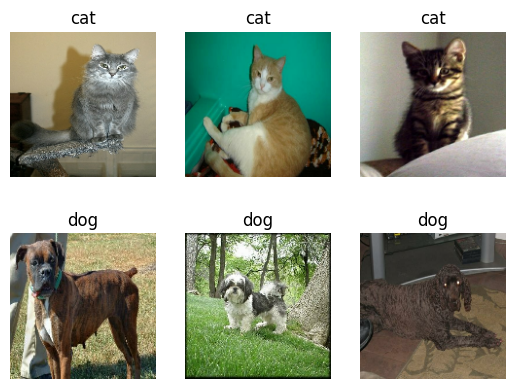

In [10]:
two_rows(train_ds)

### Check Label Frequencies
The following line of code will create an iterator called `labels_iterator`.

In [8]:
# create an iterator: tensorflow to numpy
labels_iterator= train_ds.unbatch().map(lambda image, label: label).as_numpy_iterator()

In [55]:
cat_count = 0
dog_count = 1

# count the total number for each label
for i in labels_iterator:
  if i == 0:
    cat_count += 1 # for cats
  else:
    dog_count += 1 # for dogs

print(f"Number of 'cat' images (label 0): {cat_count}")
print(f"Number of 'dog' images (label 1): {dog_count}")

Number of 'cat' images (label 0): 4637
Number of 'dog' images (label 1): 4669


In this scenario, the `baseline` model would always predict the most frequent label, which is label 1 ("dog") since there are 4669 dog images compared to 4637 cat images. As shown below, the `baseline` model would only give an accuracy of around 50% due to the fairly even split between the distribution of the two labels in the dataset.

In [57]:
total_images = cat_count + dog_count
most_frequent_label = max(cat_count, dog_count)
# baseline goes w/ most frequent label 
# --> its accuracy is the proportion of the most frequent label out of the total
baseline_accuracy = most_frequent_label / total_images
baseline_accuracy


0.501719320868257

## 2. First Model
Create a `keras.Sequential` model using some of the layers we’ve discussed in class. In each model, include at least two `Conv2D` layers, at least two `MaxPooling2D` layers, at least one `Flatten` layer, at least one `Dense` layer, and at least one `Dropout` layer. Train your model and plot the history of the accuracy on both the training and validation sets. Give your model the name `model1`.

Note: A dropout of 0.5 means that there's a 50% chance that any given unit in the dense layer will be set to zero during training.

In [70]:
# Check image sizes
for images, labels in train_ds.take(1):
  print(images[0].shape)

(150, 150, 3)


In [11]:
model1 = models.Sequential([
    layers.Input((150, 150, 3)), # input shape of the image which is 150x150 pixels with 3 channels
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(), # make it 1D
    layers.Dense(64, activation='relu'), # 64 neurons
    layers.Dropout(0.25), # to combat overfitting
    layers.Dense(2)
])

In [73]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_95 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_70 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_71 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 64)                  │       4,735,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,291,432 (54.52 MB)

 Trainable params: 4,763,810 (18.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,527,622 (36.34 MB)

In [12]:
# compile model
model1.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# train model
history = model1.fit(train_ds,
                     epochs=20,
                     validation_data=validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5024 - loss: 4.7313 - val_accuracy: 0.5589 - val_loss: 0.6745
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5685 - loss: 0.6828 - val_accuracy: 0.6161 - val_loss: 0.6527
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6056 - loss: 0.6536 - val_accuracy: 0.6651 - val_loss: 0.6096
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6701 - loss: 0.6093 - val_accuracy: 0.6728 - val_loss: 0.5980
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7079 - loss: 0.5759 - val_accuracy: 0.6999 - val_loss: 0.5659
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7256 - loss: 0.5427 - val_accuracy: 0.7154 - val_loss: 0.5533
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7391 - loss: 0.5211 - val_accuracy: 0.6655 - val_loss: 0.6211
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7506 - loss: 0.5057 - val_accu

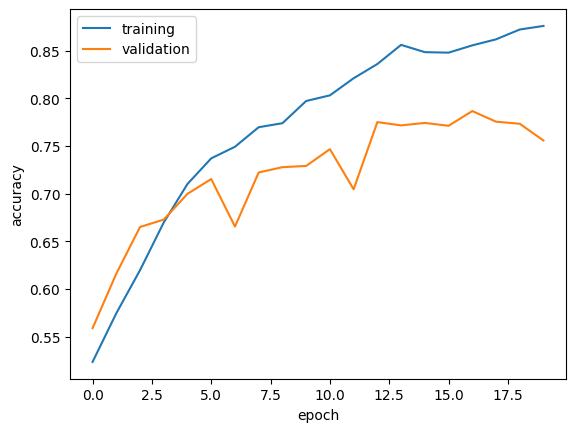

In [14]:
#plot accuracy metrics
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

At first, I tried running the model with only two `Conv2D` and `MaxPooling2D` layers but the accuracy was only in the sixties.

Therefore, I another `Conv2D` and `MaxPooling2D` layer and this increased the validation accuracy.

But to the answer the questions posed:
1. **The validation accuracy of my model stabilized between 75% and 77% during training.**
2. I did at least 25% better than the `baseline` accuracy of approximately 50%.
3. There is definitely overfitting in `model1` since the training accuracy is above 88% while the highest valiation accuracy was around 78%.

## 3. Model with Data Augmentation
First, create a `keras.layers.RandomFlip()` layer. Make a plot of the original image and a few copies to which RandomFlip() has been applied.

<ipython-input-25-e8dc3650173a>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 3, i + 1)


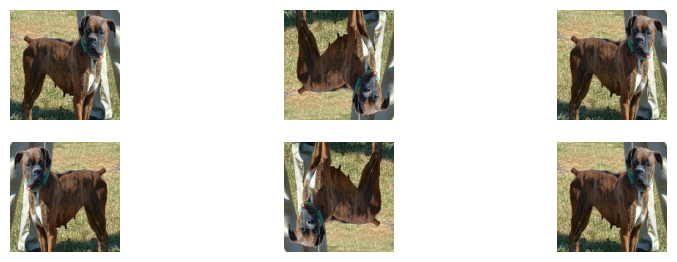

In [25]:
# create keras.layers.RandomFlip() layer
random_flip = keras.layers.RandomFlip()

for image, label in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  # plot original image
  plt.imshow(first_image)
  for i in range(6):
    ax = plt.subplot(6, 3, i + 1)
    # plot RandomFlip image
    augmented_image = random_flip(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

Next, create a `keras.layers.RandomRotation()` layer. Then, make a plot of both the original image and a few copies to which RandomRotation() has been applied. Now, create a new `keras.models.Sequential` model called `model2` in which the first two layers are augmentation layers. Use a `RandomFlip()` layer and a `RandomRotation()` layer. Train your model, and visualize the training history.

<ipython-input-28-a47955009e78>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 3, i + 1)


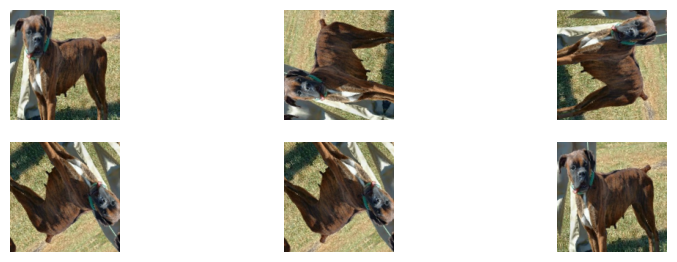

In [28]:
# create RandomRotation() layer
random_rotation = keras.layers.RandomRotation(0.5)

for image, label in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  # plot original image
  plt.imshow(first_image)
  for i in range(6):
    ax = plt.subplot(6, 3, i + 1)
    # plot RandomRotation image
    augmented_image = random_rotation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

In [21]:
model2 = models.Sequential([
    layers.Input((150, 150, 3)),
    layers.RandomFlip(), # RandomFlip() layer
    layers.RandomRotation(factor=0.2), # RandomRotation() layer
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(), # flatten into 1D 
    layers.Dense(64, activation='relu'), # 64 neurons
    layers.Dropout(0.25), # to help prevent overfitting
    layers.Dense(2) # binary classification
])

In [22]:
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_5 (RandomFlip)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_5 (RandomRotation)   │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 47, 47, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 13, 13, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 2, 2, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,466 (212.76 KB)

 Trainable params: 54,466 (212.76 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# compile model
model2.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# train model 
history = model2.fit(train_ds,
                     epochs=20,
                     validation_data=validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 45s 292ms/step - accuracy: 0.5200 - loss: 1.7734 - val_accuracy: 0.5451 - val_loss: 0.6885
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 247ms/step - accuracy: 0.5615 - loss: 0.6818 - val_accuracy: 0.6126 - val_loss: 0.6612
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 246ms/step - accuracy: 0.6163 - loss: 0.6536 - val_accuracy: 0.6032 - val_loss: 0.6488
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - accuracy: 0.6283 - loss: 0.6475 - val_accuracy: 0.6040 - val_loss: 0.6414
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 244ms/step - accuracy: 0.6516 - loss: 0.6243 - val_accuracy: 0.6896 - val_loss: 0.5828
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 35s 242ms/step - accuracy: 0.6628 - loss: 0.6092 - val_accuracy: 0.6999 - val_loss: 0.5631
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 35s 240ms/step - accuracy: 0.6804 - loss: 0.5990 - val_accuracy: 0.7068 - val_loss: 0.5709
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 248ms/step - accuracy: 0.6837 - loss: 0

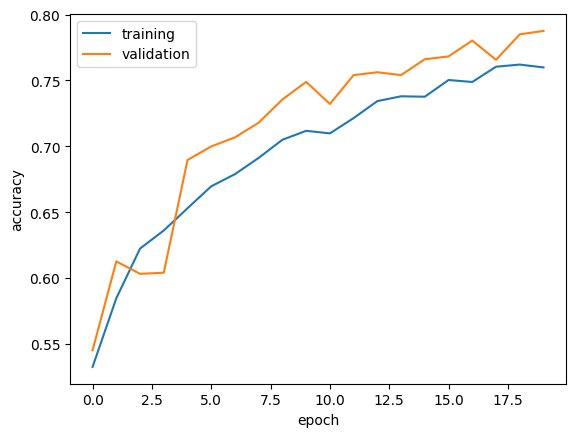

In [25]:
# plot accuracy metrics
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

At first, I tried to run essentially the same model as `model1` except for the fact that I added 2 layers of RandomFlip() and RandomRotation(). However, since the accuracy was really low, I decided to add one more `Conv2D` and `MaxPooling2D`.

Now to answer the questions posed:
1. **The validation accuracy of my model stabilized between 76% and 78% during training.**
2. Without removing the `Dropout` layers and just adding the RandomFlip() and RandomRotation() layers, the training and validation accuracies were both significantly lower than `model1`. However, after adding one more `Conv2D` and `MaxPooling2D` the validation accuracy was higher than that of `model1`.
3. Since the difference between training and validation accuracies is pretty small, there is no overfitting observed in `model2`.

## 4. Data Preprocessing
The initial dataset consists of images with RGB pixel values ranging from 0 to 255. However, normalizing these RGB values to a range of 0 to 1, or even -1 to 1, can accelerate the training of many models. Both normalization options are fundamentally equivalent as the model's weights can be scaled accordingly. By scaling the data before training, the model can focus more on learning from the actual data rather than spending resources adjusting its weights to the scale of the data.

Below is a code snippet that sets up a preprocessing layer named `preprocessor`. This layer can be seamlessly integrated into your model's processing pipeline.

In [52]:
i = keras.Input(shape=(150, 150, 3))
# The pixel values have the range of (0, 255), but many models will work better if rescaled to (-1, 1.)
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(i)
preprocessor = keras.Model(inputs = [i], outputs = x)

model3 = models.Sequential([
    preprocessor,
    layers.RandomFlip(), # RandomFlip() layer
    layers.RandomRotation(factor=0.2), # RandomRotation() layer
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(), # to convert into 1D 
    layers.Dense(64, activation='relu'), # 64 neutrons
    layers.Dropout(0.25), # to help prevent overfitting
    layers.Dense(2) # binary classification
])


In [50]:
model3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_62 (Functional)           │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_29 (RandomFlip)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_26 (RandomRotation)  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [53]:
# compile model
model3.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# train model
history = model3.fit(train_ds,
                     epochs=20,
                     validation_data=validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 48s 309ms/step - accuracy: 0.5414 - loss: 0.6860 - val_accuracy: 0.6642 - val_loss: 0.6114
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 35s 240ms/step - accuracy: 0.6531 - loss: 0.6267 - val_accuracy: 0.7111 - val_loss: 0.5602
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 244ms/step - accuracy: 0.6996 - loss: 0.5771 - val_accuracy: 0.7094 - val_loss: 0.5618
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - accuracy: 0.7143 - loss: 0.5603 - val_accuracy: 0.7494 - val_loss: 0.5126
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 37s 257ms/step - accuracy: 0.7224 - loss: 0.5442 - val_accuracy: 0.7528 - val_loss: 0.5237
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 37s 251ms/step - accuracy: 0.7341 - loss: 0.5263 - val_accuracy: 0.7704 - val_loss: 0.4820
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 289ms/step - accuracy: 0.7435 - loss: 0.5193 - val_accuracy: 0.7678 - val_loss: 0.4805
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 289ms/step - accuracy: 0.7590 - loss: 0

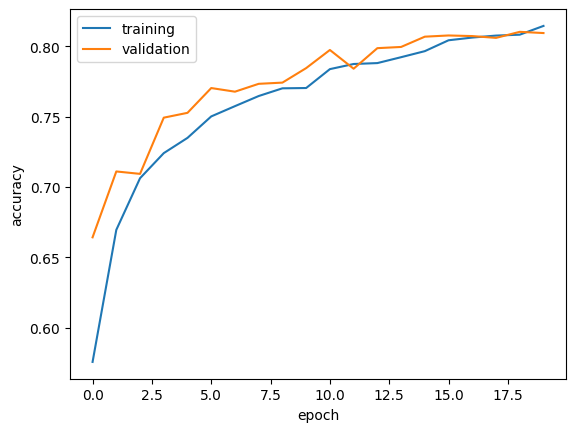

In [54]:
# plot accuracy metrics
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

1. **The validation accuracy of `model3` stabilized bewtween 80% and 81%.**
2. The validation accuracy of `model3` is higher than that of `model1`'s by around 5%.
3. No overfitting is observed because the training and validation accuracies are around the same.

## 5. Transfer Learning

Up to this point, our approach has involved training models from the ground up to tell cats apart from dogs. Sometimes, though, there might be a model out there already trained on a similar problem that has picked up patterns which could be useful for our task. Consider that there's a whole range of machine learning models designed for recognizing different images. What if we could leverage one of these already-trained models for our purpose?

To make this work, we'd start by selecting a `base model` that's been pre-trained. We'd then integrate this base model into a new model tailored to our specific need — distinguishing cats from dogs. The final step would be to train this newly created model on our task.

In [39]:
IMG_SHAPE = (150, 150, 3)
# use the pre-trained `base model` 
base_model = keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = keras.Model(inputs = i, outputs = x)

model4 = models.Sequential([
    layers.RandomFlip(), # random flip layer
    layers.RandomRotation(factor=0.2),# random rotation layer
    base_model_layer, # add in the `base model` as a layer
    layers.Flatten(), # flatten into 1D
    layers.Dense(2) # binary classification
])

In [40]:
model4.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_24 (RandomFlip)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_21 (RandomRotation)  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_51 (Functional)           │ ?                           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

In [41]:
# compile model
model4.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# train model
history = model4.fit(train_ds,
                     epochs=20,
                     validation_data=validation_ds)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 59s 407ms/step - accuracy: 0.8458 - loss: 0.9495 - val_accuracy: 0.9256 - val_loss: 0.6401
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 93s 637ms/step - accuracy: 0.8997 - loss: 0.7836 - val_accuracy: 0.9570 - val_loss: 0.3779
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 58s 397ms/step - accuracy: 0.9281 - loss: 0.5967 - val_accuracy: 0.9570 - val_loss: 0.4549
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 57s 394ms/step - accuracy: 0.9240 - loss: 0.7070 - val_accuracy: 0.9463 - val_loss: 0.6327
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 93s 635ms/step - accuracy: 0.9217 - loss: 0.7699 - val_accuracy: 0.9510 - val_loss: 0.6831
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 60s 412ms/step - accuracy: 0.9237 - loss: 0.8422 - val_accuracy: 0.9561 - val_loss: 0.5213
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 92s 629ms/step - accuracy: 0.9339 - loss: 0.7602 - val_accuracy: 0.9639 - val_loss: 0.4528
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 61s 421ms/step - accuracy: 0.9319 - loss: 0

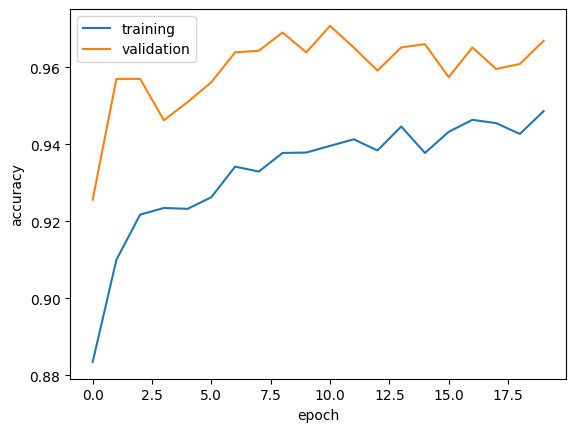

In [42]:
# plot accuracy metrics
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

From the model summary, we see that there are 2,996,352 parameters, which is a lot and shows the complexity hidden in the `base_model_layer`

1. **The validation accuracy of my model stabilized between 95% and 96%.**
2. The validation accuracy of `model4` far surpasses the validation accuracy of `model1` by around 20%.
3. There is no overfitting observed because the training and validation accuracies are very close to each other.

## 6. Score on Test Data

In [55]:
#evaluate on test data
loss, accuracy = model4.evaluate(test_ds)
print('Test accuracy :', accuracy)

37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 560ms/step - accuracy: 0.9602 - loss: 0.6515
Test accuracy : 0.9557179808616638


The final model obtained a test accuracy of approximately 95%.